In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import pandas as pd
%matplotlib inline

In [2]:
import scipy.cluster.hierarchy as sch

In [3]:
import context
from hier_clust import linkage_util, HierClust
from hier_clust.tree_util import Tree

In [4]:
from gen_data_util import gen_data, plot_tree_overlay

In [5]:
np.random.seed(1)

In [6]:
depth = 10
n_obs = 2 ** depth
n_dim = 10

In [7]:
x, y = gen_data(depth = depth, n_dim = n_dim, depth_labels = 3)

In [8]:
indices = np.arange(n_obs)
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [9]:
print(x.shape)
print(y.shape)

(1024, 10)
(1024,)


In [10]:
# fig, ax = plt.subplots()
# for yi in np.unique(y):
#     ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
#
# None

In [11]:
# %%time
# # Use this for "with downsampling" tests
# hc = HierClust(n_neighbors=200)
# t, _ = hc.fit(x)

In [12]:
%%time
# No downsampling, ball tree
hc = HierClust(n_neighbors=200, neighbor_graph_strategy='balltree')
t, _ = hc.fit(x)

CPU times: user 5.99 s, sys: 142 ms, total: 6.14 s
Wall time: 6.12 s


In [13]:
# %%time
# # No downsampling, RP tree
# hc = HierClust(n_neighbors=200, neighbor_graph_strategy='rptree')
# t, _ = hc.fit(x)

In [14]:
# %%time
# # Bottom-up clustering
# link = sch.linkage(x, method='complete')

In [15]:
# t = linkage_util.linkage_to_tree(link)

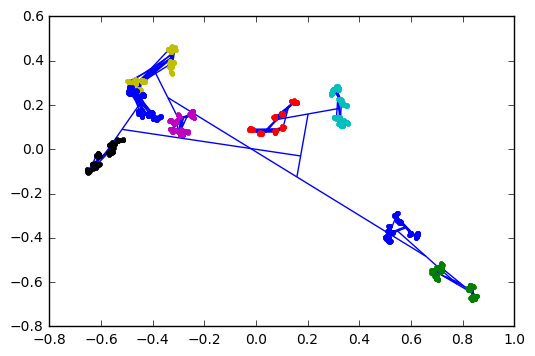

In [16]:
fig, ax = plt.subplots()
for yi in np.unique(y):
    ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
plot_tree_overlay(data = x, tree = t, max_depth = 10, ax = ax)

None

In [17]:
plt.close()